# Prediction using Supervised ML(Level-Beginner)

Task: To predict the percentage of marks of an student based on the number of study hours by using a simple linear regression as it involves two variables. The data can be found at https://raw.githubusercontent.com/AdiPersonalWorks/Random/master/student_scores%20-%20student_scores.csv

Purpose: What will be predicted score if a student studies for 9.25 hrs/ day?

In [1]:
#for data
import pandas as pd
import numpy as np

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

#for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics,decomposition

#for explainer
from lime import lime_tabular

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/AdiPersonalWorks/Random/master/student_scores%20-%20student_scores.csv")
df.reset_index(inplace=True)
df.rename(columns={'index': 'Id'}, inplace=True)
df.head()

,Id,Hours,Scores
0,0,2.5,21
1,1,5.1,47
2,2,3.2,27
3,3,8.5,75
4,4,3.5,30


## Exploratory Data Analysis

#### Recognize whether a column is numerical or categorical

In [3]:
def utils_recognize_type(df, col, max_cat=20):
    if (df[col].dtypes == int) |(df[col].nunique() < max_cat):
        return 'cat'
    else:
        return 'num'

For several occasions with the real world datasets, there are many missing data. This function is to give an illustration of a heatmap of the dataframe and visualize columns to check type and missing data.

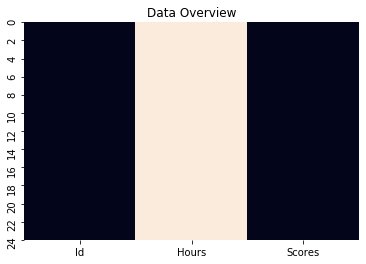

 Categoricial  Numeric  NaN


In [4]:
dic_cols = {col:utils_recognize_type(df, col, max_cat=20) for col in df.columns}

heatmap = df.isnull()
for k, v in dic_cols.items():
    if v == 'num':
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)

sns.heatmap(heatmap, cbar=False).set_title('Data Overview')
plt.show()

print("\033[1;37;40m Categoricial", "\033[1;30;41m Numeric", "\033[1;30;47m NaN")

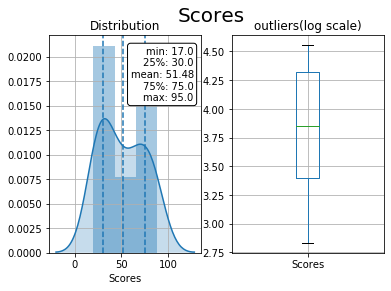

In [5]:
x = "Scores"

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)

## Distribution
ax[0].title.set_text('Distribution')
variable = df[x].fillna(df[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < breaks[10]) ]

sns.distplot(variable, hist=True, kde=True, kde_kws={'shade': True}, ax=ax[0])
des = df[x].describe()
ax[0].axvline(des['25%'], ls='--')
ax[0].axvline(des['mean'], ls='--')
ax[0].axvline(des['75%'], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(('min: '+des['min'], '25%: '+des['25%'], 
                 'mean: '+des['mean'], '75%: '+des['75%'], 'max: '+des['max']))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, 
          va='top', ha='right', bbox=dict(boxstyle='round', facecolor='white', alpha=1))

## Boxplot
ax[1].title.set_text('outliers(log scale)')
tmp_df = pd.DataFrame(df[x])
tmp_df[x] = np.log(tmp_df[x])
tmp_df.boxplot(column=x, ax=ax[1])
plt.show()


/Users/gympohnpimol/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/gympohnpimol/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


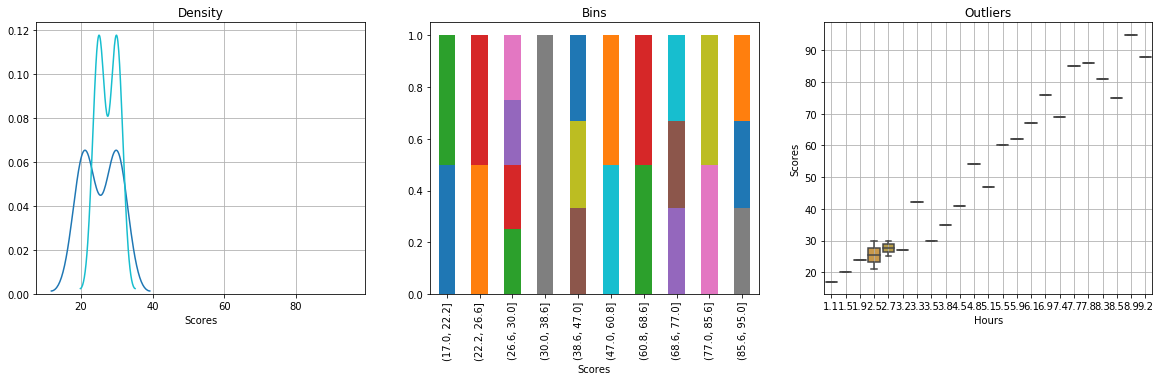

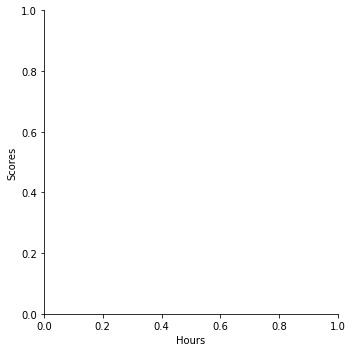

In [6]:
cat, num = 'Hours', 'Scores'

fix, ax = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(20,5))
fig.suptitle('Hours vs Scores', fontsize=20)

## Distribution
ax[0].title.set_text('Density')
for i in df[cat].unique():
    sns.distplot(df[df[cat]==i][num], hist=False, ax=ax[0])
ax[0].grid(True)

## Stacked
ax[1].title.set_text('Bins')
breaks = np.quantile(df[num], q=np.linspace(0, 1, 11))
tmp = df.groupby([cat, pd.cut(df[num], breaks, duplicates='drop')]).size().unstack().T
tmp['tot'] = tmp.sum(axis=1)
for col in tmp.drop('tot', axis=1).columns:
    tmp[col] = tmp[col]/tmp['tot']
tmp.drop('tot', axis=1).plot(kind='bar', stacked=True, ax=ax[1],
                            legend=False, grid=False)

## Boxplot
ax[2].title.set_text('Outliers')
sns.catplot(x=cat, y=num, data=df, kind='box', ax=ax[2])
ax[2].grid(True)
plt.show()

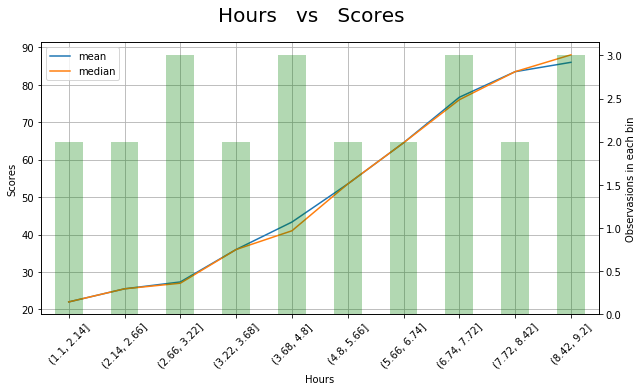

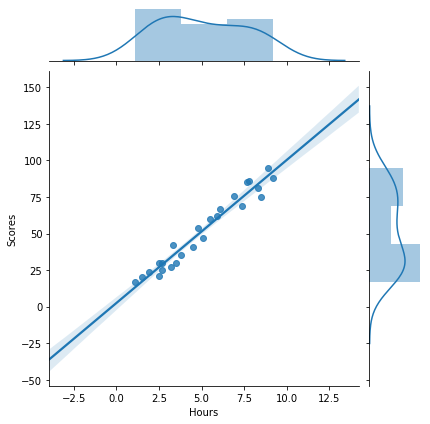

In [7]:
x, y = 'Hours', 'Scores'

## Bin plot
df_noNan = df[df[x].notnull()]
breaks = np.quantile(df_noNan[x], q=np.linspace(0, 1, 11))
groups = df_noNan.groupby([pd.cut(df_noNan[x], bins=breaks,
                         duplicates='drop')])[y].agg(['mean', 'median', 'size'])
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle(x+'   vs   '+y, fontsize=20)
groups[['mean', 'median']].plot(kind='line', ax=ax)
groups['size'].plot(kind='bar', ax=ax, rot=45, secondary_y=True,
                   color='green', alpha=0.3, grid=True)
ax.set(ylabel=y)
ax.right_ax.set_ylabel('Observasions in each bin')
plt.show()

## Scatter plot
sns.jointplot(x=x, y=y, data=df, dropna=True, kind='reg')
plt.show()

## Preprocessing 

In [8]:
## split data
df = df.drop('Id', axis=1)
df_train, df_test = model_selection.train_test_split(df, test_size=0.3)

## scale X
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X = scalerX.fit_transform(df_train.drop('Scores', axis=1))

df_scaled = pd.DataFrame(X, columns=df_train.drop('Scores', axis=1).columns, index=df_train.index)

## scale Y
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
df_scaled[y] = scalerY.fit_transform(df_train[y].values.reshape(-1, 1))
df_scaled.head()

,Hours,Scores
24,0.66,0.916667
16,-0.40,-0.250000
3,0.80,0.687500
10,0.64,0.895833
18,0.32,0.520833


## Feature Selection

Text(0.5, 1, 'Pearson Correlation')

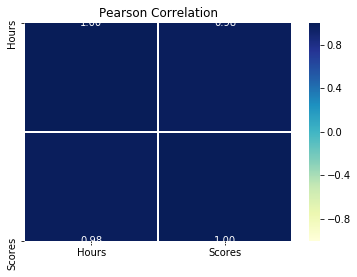

In [9]:
corr_matrix = df_train.corr(method='pearson')
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f',
           cmap='YlGnBu', cbar=True, linewidths=0.5)
plt.title('Pearson Correlation')

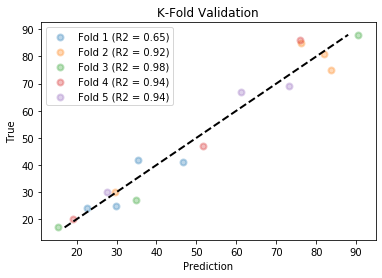

In [16]:
X = df_train.drop('Scores', axis=1).values
y = df_train['Scores'].values
feature_names = df_train.drop('Scores', axis=1).columns

X_names = ['Hours']

X_train = df_train[X_names].values
y_train = df_train['Scores'].values

X_test = df_test[X_names].values
y_test = df_test['Scores'].values

## call model
model = linear_model.LinearRegression()

## K fold validation
scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                          y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' %(i,score))
    i = i+1
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)],
        ls='--', lw=2, color='black')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()